# IA PARA CIENCIA DE DATOS

## 1. Packaging

In [24]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)

# Matplotlib and seaborn for charting
import matplotlib.pyplot as plt # to plot
import seaborn as sns # to plot

In [25]:
# Sklearn processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Sklearn classification model evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [26]:
# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout,  GlobalAveragePooling1D

In [27]:
# Custom analysis modules
from analysis_modules import *

np.random.seed(0)
tf.random.set_seed(0) 

## 2. Read file and load data

### 2.1 Read file

In [28]:
# Load data
data_file = "Amazon_Unlocked_Mobile.csv"
datos = pd.read_csv(data_file, header=0)

In [29]:
# View data information
describeData(datos)

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data co

### 2.2 Preprocessing

In [30]:
def encodeData(dataSet=0):
    """
    Preprocess data
    """
    
    # Eliminate null values
    dataSet.dropna(inplace=True)
    # Work with a sample of 100,000 rows
    dataSet = dataSet.iloc[0:100000,:]

    # Remove any 'neutral' ratings equal to 3
    dataSet = dataSet[dataSet['Rating'] != 3]

    # Encode 4s and 5s as 1 (rated positively)
    # Encode 1s and 2s as 0 (rated poorly)
    dataSet['Clasification'] = np.where(dataSet['Rating'] > 3, 1, 0)

    # Keep only relevant columns
    columnas = ['Reviews', 'Rating', 'Clasification']
    dataSet = dataSet[columnas]

    return dataSet

In [31]:
# Preprocess data
misDatos = encodeData(datos)
print(misDatos.head())
print()
print(misDatos.iloc[:,-1:].sum())
print()

                                             Reviews  Rating  Clasification
0  I feel so LUCKY to have found this used (phone...       5              1
1  nice phone, nice up grade from my pantach revu...       4              1
2                                       Very pleased       5              1
3  It works good but it goes slow sometimes but i...       4              1
4  Great phone to replace my lost phone. The only...       4              1

Clasification    70037
dtype: int64



### 2.3 Split Data

In [32]:
columnas = ['Reviews', 'Clasification']
misDatos = misDatos[columnas]
print(misDatos.head())

                                             Reviews  Clasification
0  I feel so LUCKY to have found this used (phone...              1
1  nice phone, nice up grade from my pantach revu...              1
2                                       Very pleased              1
3  It works good but it goes slow sometimes but i...              1
4  Great phone to replace my lost phone. The only...              1


In [33]:
# Extract labels
# Convert one-hot encoding to single label
y_onehot = misDatos.iloc[:, -1:].to_numpy()
y_label = np.argmax(y_onehot, axis=1)

# Split data into training and test sets
ts_size = .25
[trainSet, testSet] = splitDataSet(misDatos, test_size=ts_size, randSplit=True, stratify=y_label)
print("Train set")
print(trainSet.head())
print()
print('trainSet shape: ', trainSet.shape)
print()
print(trainSet.iloc[:,-1:].sum())
print()
print("Test set")
print(testSet.head())
print()
print('testSet shape: ', testSet.shape)
print()
print(testSet.iloc[:,-1:].sum())
print()

Train set
                                                  Reviews  Clasification
2267    Great build quality. Almost stock Android. Lit...              1
88968                                          excelente!              1
94479   Soy de venezuela el producto vino malo, lo man...              0
113000                                         Excelente.              1
72560                                                good              1

trainSet shape:  (70160, 2)

Clasification    52501
dtype: int64

Test set
                                                 Reviews  Clasification
44794  The selphone is super nice ,my daugter love't ...              1
25359  No it did not, you can't hear when you have it...              0
59842  The iPhone 6 Plus arrived on-time and in perfe...              1
69634  Finally picked one up after a year of contempl...              1
19566  I bought this used and it had few noticeable s...              1

testSet shape:  (23387, 2)

Clasification  

### 2.4 Vectorize

In [34]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

training_sentences= trainSet['Reviews']
training_labels = trainSet['Clasification']
testing_sentences = testSet['Reviews']
testing_labels = testSet['Clasification']

In [35]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [36]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## 3. NN - MLP

In [37]:
# NN MLP classifier
# Neural Networks TF architecture
dropout_rate = 0.25
model = Sequential([
                    Embedding(vocab_size, embedding_dim, input_length=max_length),
                    GlobalAveragePooling1D(),
                    Dense(3, activation='relu'),
                    Dropout(dropout_rate),
                    Dense(1, activation='sigmoid')
                    ])

opt = 'adam'
loss_fun = 'binary_crossentropy'
acc = ['accuracy']

model.compile(
    optimizer = opt,
    loss = loss_fun,
    metrics = acc
    )

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 160,055
Trainable params: 160,055
Non-trainable params: 0
________________________________________________

In [39]:
num_epochs = 30
history = model.fit(training_padded,
                    training_labels,
                    validation_split=0.4,
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/30
1316/1316 - 6s - loss: 0.4703 - accuracy: 0.7959 - val_loss: 0.3025 - val_accuracy: 0.8853 - 6s/epoch - 4ms/step
Epoch 2/30
1316/1316 - 4s - loss: 0.2813 - accuracy: 0.8758 - val_loss: 0.1946 - val_accuracy: 0.9388 - 4s/epoch - 3ms/step
Epoch 3/30
1316/1316 - 4s - loss: 0.2243 - accuracy: 0.8939 - val_loss: 0.1619 - val_accuracy: 0.9433 - 4s/epoch - 3ms/step
Epoch 4/30
1316/1316 - 6s - loss: 0.2024 - accuracy: 0.9041 - val_loss: 0.1507 - val_accuracy: 0.9472 - 6s/epoch - 4ms/step
Epoch 5/30
1316/1316 - 6s - loss: 0.1863 - accuracy: 0.9076 - val_loss: 0.1396 - val_accuracy: 0.9550 - 6s/epoch - 4ms/step
Epoch 6/30
1316/1316 - 4s - loss: 0.1757 - accuracy: 0.9101 - val_loss: 0.1322 - val_accuracy: 0.9567 - 4s/epoch - 3ms/step
Epoch 7/30
1316/1316 - 5s - loss: 0.1696 - accuracy: 0.9097 - val_loss: 0.1308 - val_accuracy: 0.9566 - 5s/epoch - 4ms/step
Epoch 8/30
1316/1316 - 6s - loss: 0.1601 - accuracy: 0.9220 - val_loss: 0.1269 - val_accuracy: 0.9582 - 6s/epoch - 5ms/step
Epoch 9/

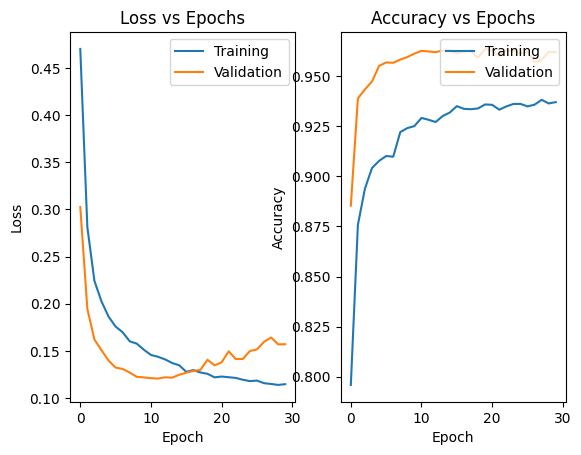

In [40]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 4. Metrics

In [41]:
print(model.evaluate(training_padded, training_labels, verbose=2))
print("\n")

#### predict train data ######
df_train = pd.DataFrame()
df_train['pred'] = model.predict(training_padded).reshape(1,len(training_padded))[0]
df_train['real'] = training_labels
print(round(df_train))
print(model.evaluate(testing_padded,testing_labels, verbose=2))
print("\n")

# test data
df_test = pd.DataFrame()
df_test['pred'] = model.predict(testing_padded).reshape(1,len(testing_padded))[0]
df_test['real'] = testing_labels
print(round(df_test))


2193/2193 - 3s - loss: 0.0865 - accuracy: 0.9755 - 3s/epoch - 1ms/step
[0.08651763945817947, 0.9754703640937805]


2193/2193 [==============================] - 6s 3ms/step
       pred  real
0       1.0     1
1       1.0     1
2       0.0     0
3       1.0     1
4       1.0     1
...     ...   ...
70155   1.0     1
70156   1.0     1
70157   0.0     0
70158   1.0     1
70159   0.0     0

[70160 rows x 2 columns]
731/731 - 1s - loss: 0.1518 - accuracy: 0.9628 - 1s/epoch - 2ms/step
[0.15179790556430817, 0.962842583656311]


731/731 [==============================] - 1s 1ms/step
       pred  real
0       1.0     1
1       0.0     0
2       1.0     1
3       1.0     1
4       1.0     1
...     ...   ...
23382   1.0     1
23383   0.0     0
23384   1.0     1
23385   1.0     1
23386   1.0     1

[23387 rows x 2 columns]
